# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import chart_studio.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

Output hidden; open in https://colab.research.google.com to view.

In [7]:
from google.colab import files
uploaded = files.upload()

Saving train_data.csv to train_data.csv


## 1.1 Reading Data

In [0]:
project_data = pd.read_csv('train_data.csv', nrows=35000)
resource_data = pd.read_csv('resources.csv')
project_data = project_data[pd.notnull(project_data['teacher_prefix'])]


In [10]:
project_data.isnull().sum()

Unnamed: 0                                          0
id                                                  0
teacher_id                                          0
teacher_prefix                                      0
school_state                                        0
project_submitted_datetime                          0
project_grade_category                              0
project_subject_categories                          0
project_subject_subcategories                       0
project_title                                       0
project_essay_1                                     0
project_essay_2                                     0
project_essay_3                                 33812
project_essay_4                                 33812
project_resource_summary                            0
teacher_number_of_previously_posted_projects        0
project_is_approved                                 0
dtype: int64

In [11]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (34998, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [12]:
y = project_data['project_is_approved'].values
#project_data.drop(['project_is_approved'], axis=1, inplace=True)
project_data.head(1)



,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0


## 1.3 preprocessing of `project_subject_categories`


In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [14]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades PreK-2,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades 6-8,"Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports


## 1.3 preprocessing of `project_subject_subcategories`

In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [16]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports


In [17]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ', '_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-', '_')
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades_PreK_2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades_6_8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports


## 1.4 Merging datasets

In [18]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(5)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8


In [0]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [20]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades_PreK_2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,154.6,23


## 1.3 Text preprocessing

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [22]:
# we get the cost of the project using resource.csv file
resource_data.head(5)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [25]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 34998/34998 [00:14<00:00, 2377.40it/s]


In [26]:
project_data["essay"] = preprocessed_essays

project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades_PreK_2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,154.6,23,my students english learners working english s...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades_6_8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,299.0,1,our students arrive school eager learn they po...


In [27]:
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    title = decontracted(sentance)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    # https://gist.github.com/sebleier/554280
    title = ' '.join(e for e in title.split() if e not in stopwords)
    preprocessed_titles.append(title.lower().strip())

100%|██████████| 34998/34998 [00:00<00:00, 50601.25it/s]


In [28]:
project_data["project_title"] = preprocessed_titles

project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades_PreK_2,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,154.6,23,my students english learners working english s...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades_6_8,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,299.0,1,our students arrive school eager learn they po...


In [29]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for essay in project_data:
    essay.lower()
    ss = sid.polarity_scores(essay)

    for k in ss:
        project_data['compound_rate'] = ss['compound']
        project_data['pos_rate']= ss['pos']
        project_data['neu_rate']= ss['neu']
        project_data['neg_rate']= ss['neg']
                
print(project_data['compound_rate'].shape)
project_data.head(2)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
(34998,)


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity,essay,compound_rate,pos_rate,neu_rate,neg_rate
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,05-12-2016 13:43,Grades_PreK_2,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,154.6,23,my students english learners working english s...,0.0,0.0,1.0,0.0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,25-10-2016 09:22,Grades_6_8,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,299.0,1,our students arrive school eager learn they po...,0.0,0.0,1.0,0.0


In [0]:
 project_data['essay_n_words'] = project_data['essay'].apply(lambda row: len(row.split(" ")))

## 1.5 Sorting according to date

In [31]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity,essay,compound_rate,pos_rate,neu_rate,neg_rate,essay_n_words
31475,47750,p185738,3afe10b996b7646d8641985a4b4b570d,Mrs.,UT,2016-01-05 01:05:00,Grades_PreK_2,math fun,"\""The only way to learn mathematics is to do m...",My students love coming to school and working ...,My students will be using these math manipulat...,Learning about money is important so the stude...,"My students need base ten blocks, realistic pl...",0,1,Math_Science,Mathematics,218.17,12,the way learn mathematics mathematics paul hal...,0.0,0.0,1.0,0.0,125
3287,159755,p147002,6ada7036aeb258d3653589d1f2a5b815,Mrs.,CA,2016-01-05 02:02:00,Grades_3_5,multimedia apps game,My students need new ways to learn. Research i...,My students are elementary students in kinderg...,My students are pulled from their general educ...,This donation will improve motivate my student...,My students need multimedia comprehension mate...,2,0,Literacy_Language SpecialNeeds,Literacy SpecialNeeds,157.91,5,my students need new ways learn research indic...,0.0,0.0,1.0,0.0,97


In [32]:
project_data["project_title"] = preprocessed_titles
project_data['title_n_words'] = project_data['project_title'].apply(lambda row: len(row.split(" ")))
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity,essay,compound_rate,pos_rate,neu_rate,neg_rate,essay_n_words,title_n_words
31475,47750,p185738,3afe10b996b7646d8641985a4b4b570d,Mrs.,UT,2016-01-05 01:05:00,Grades_PreK_2,educational support english learners home,"\""The only way to learn mathematics is to do m...",My students love coming to school and working ...,My students will be using these math manipulat...,Learning about money is important so the stude...,"My students need base ten blocks, realistic pl...",0,1,Math_Science,Mathematics,218.17,12,the way learn mathematics mathematics paul hal...,0.0,0.0,1.0,0.0,125,5
3287,159755,p147002,6ada7036aeb258d3653589d1f2a5b815,Mrs.,CA,2016-01-05 02:02:00,Grades_3_5,wanted projector hungry learners,My students need new ways to learn. Research i...,My students are elementary students in kinderg...,My students are pulled from their general educ...,This donation will improve motivate my student...,My students need multimedia comprehension mate...,2,0,Literacy_Language SpecialNeeds,Literacy SpecialNeeds,157.91,5,my students need new ways learn research indic...,0.0,0.0,1.0,0.0,97,4


In [0]:
X=project_data

## 1.6 Splitting data

In [0]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

  

In [35]:
print(X.shape)
print(X_train.shape)

print(X_test.shape)
print(y.shape)
print(y_train.shape)

print(y_test.shape)


(34998, 26)
(23448, 26)
(11550, 26)
(34998,)
(23448,)
(11550,)


we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# Assignment 9: RF and GBDT

#### Response Coding: Example

<img src='response.JPG' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply both Random Forrest and GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters preferably n_estimators, max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You can choose either of the plotting techniques: 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
            </ul>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. Random Forest and GBDT </h1>

<h2>2.1 Make Data Model Ready: encoding numerical, categorical features</h2>

In [0]:

def get_gv_fea_dict(alpha, feature, df):

    value_count = X_train[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(0,2):
            

            cls_cnt = X_train.loc[(X_train['project_is_approved']==k) & (X_train[feature]==i)]
            
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        gv_dict[i]=vec
    return gv_dict


def get_gv_feature(alpha, feature, df):
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)

    value_count = X_train[feature].value_counts()
    
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [38]:

# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_categories_feature_responseCoding = np.array(get_gv_feature(alpha, "clean_categories", X_train))
# test gene feature
test_categories_feature_responseCoding = np.array(get_gv_feature(alpha, "clean_categories", X_test))

test_categories_feature_responseCoding.reshape(-1,2)



print("After vectorizations")
print(train_categories_feature_responseCoding.shape, y_train.shape)

print(test_categories_feature_responseCoding.shape, y_test.shape)

print("="*100)

After vectorizations
(23448, 2) (23448,)
(11550, 2) (11550,)


In [39]:
train_categories_feature_responseCoding[1][0]

0.13090128755364808

In [40]:
X_train.shape

(23448, 26)

In [0]:
train_class1=[]
train_class2=[]
for i in range(len(test_categories_feature_responseCoding)):
    train_class1.append(test_categories_feature_responseCoding[i][0])
    train_class2.append(test_categories_feature_responseCoding[i][1])

In [42]:
test1_categories_feature_responseCoding = np.column_stack((train_class1,train_class2))

test1_categories_feature_responseCoding.shape

(11550, 2)

In [43]:

print("After vectorizations")
print(train_categories_feature_responseCoding.shape, y_train.shape)

print(test1_categories_feature_responseCoding.shape, y_test.shape)

print("="*100)

After vectorizations
(23448, 2) (23448,)
(11550, 2) (11550,)


In [44]:

# alpha is used for laplace smoothing
alpha = 1

train_subcategories_feature_responseCoding = np.array(get_gv_feature(alpha, "clean_subcategories", X_train))

test_subcategories_feature_responseCoding = np.array(get_gv_feature(alpha, "clean_subcategories", X_test))


print("After vectorizations")
print(train_subcategories_feature_responseCoding.shape, y_train.shape)

print(test_subcategories_feature_responseCoding.shape, y_test.shape)
#print(vectorizer.get_feature_names())

After vectorizations
(23448, 2) (23448,)
(11550,) (11550,)


In [45]:
train_class1=[]
train_class2=[]
for i in range(len(test_subcategories_feature_responseCoding)):
    train_class1.append(test_subcategories_feature_responseCoding[i][0])
    train_class2.append(test_subcategories_feature_responseCoding[i][1])
    
    
test1_subcategories_feature_responseCoding = np.column_stack((train_class1,train_class2))

print(test1_subcategories_feature_responseCoding.shape)

print("After vectorizations")
print(train_subcategories_feature_responseCoding.shape, y_train.shape)
print(test1_subcategories_feature_responseCoding.shape, y_test.shape)
#print(vectorizer.get_feature_names())

(11550, 2)
After vectorizations
(23448, 2) (23448,)
(11550, 2) (11550,)


In [46]:

# alpha is used for laplace smoothing
alpha = 1

train_state_feature_responseCoding = np.array(get_gv_feature(alpha, "school_state", X_train))

test_state_feature_responseCoding = np.array(get_gv_feature(alpha, "school_state", X_test))


print("After vectorizations")
print(train_state_feature_responseCoding.shape, y_train.shape)
print(test_state_feature_responseCoding.shape, y_test.shape)
#print(vectorizer.get_feature_names())

After vectorizations
(23448, 2) (23448,)
(11550, 2) (11550,)


In [47]:
train_state_feature_responseCoding

array([[0.14460512, 0.77753059],
       [0.12562814, 0.52261307],
       [0.12322275, 0.76619273],
       ...,
       [0.15577889, 0.72696817],
       [0.11589404, 0.76821192],
       [0.14311164, 0.81532067]])

In [48]:
test_state_feature_responseCoding

array([[0.1460396 , 0.68069307],
       [0.13346228, 0.7311412 ],
       [0.14613779, 0.70772443],
       ...,
       [0.14311164, 0.81532067],
       [0.13098237, 0.69269521],
       [0.11589404, 0.76821192]])

In [49]:
train_state_feature_responseCoding[2][1]

0.7661927330173776

In [50]:
# alpha is used for laplace smoothing
alpha = 1

train_teacher_feature_responseCoding = np.array(get_gv_feature(alpha, "teacher_prefix", X_train))

test_teacher_feature_responseCoding = np.array(get_gv_feature(alpha, "teacher_prefix", X_test))

print("After vectorizations")
print(train_teacher_feature_responseCoding.shape, y_train.shape)
print(test_teacher_feature_responseCoding.shape, y_test.shape)
#print(vectorizer.get_feature_names())

After vectorizations
(23448, 2) (23448,)
(11550, 2) (11550,)


In [51]:
X_train['project_grade_category'].head(20)

1732     Grades_PreK_2
31012    Grades_PreK_2
5103     Grades_PreK_2
28183    Grades_PreK_2
31595       Grades_3_5
16291       Grades_3_5
19196       Grades_6_8
3490        Grades_3_5
26444       Grades_3_5
8076     Grades_PreK_2
14743       Grades_3_5
27404    Grades_PreK_2
30348       Grades_3_5
32921       Grades_3_5
28358       Grades_6_8
13862       Grades_3_5
8611        Grades_3_5
2262        Grades_3_5
10122       Grades_3_5
16919       Grades_3_5
Name: project_grade_category, dtype: object

In [52]:
# alpha is used for laplace smoothing
alpha = 1

train_grade_feature_responseCoding = np.array(get_gv_feature(alpha, "project_grade_category", X_train))

test_grade_feature_responseCoding = np.array(get_gv_feature(alpha, "project_grade_category", X_test))


print("After vectorizations")
print(train_grade_feature_responseCoding.shape, y_train.shape)

print(test_grade_feature_responseCoding.shape, y_test.shape)
#print(vectorizer.get_feature_names())

After vectorizations
(23448, 2) (23448,)
(11550, 2) (11550,)


<h2>2.2 Make Data Model Ready: encoding eassay, and project_title</h2>

In [53]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.fit_transform(X_train['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

                                        
print("After BOW vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)


(23448, 26) (23448,)
(11550, 26) (11550,)
After BOW vectorizations
(23448, 50000) (23448,)
(11550, 50000) (11550,)


In [54]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.fit_transform(X_train['project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['project_title'].values)

                                        
print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_test_title_bow.shape, y_test.shape)
print("="*100)


(23448, 26) (23448,)
(11550, 26) (11550,)
After vectorizations
(23448, 2081) (23448,)
(11550, 2081) (11550,)


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

X_train_essay_tfidf = vectorizer.fit_transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After TFIDF vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)


After TFIDF vectorizations
(23448, 50000) (23448,)
(11550, 50000) (11550,)


In [56]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

X_train_title_tfidf = vectorizer.fit_transform(X_train['project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['project_title'].values)

print("After TFIDF vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_test_title_tfidf.shape, y_test.shape)
print("="*100)

After TFIDF vectorizations
(23448, 2081) (23448,)
(11550, 2081) (11550,)


In [57]:
# average Word2Vec
# compute average word2vec for each review.
def w2v(data) :
    avg_w2v_vectors= []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    
    print(len(avg_w2v_vectors))
    print(len(avg_w2v_vectors[0]))

X_train_essay_avg_w2v = w2v(X_train['essay'])
X_test_essay_avg_w2v = w2v(X_test['essay'])
X_train_title_avg_w2v = w2v(X_train['project_title'])
X_test_title_avg_w2v = w2v(X_test['project_title'])




  4%|▍         | 486/11550 [00:00<00:02, 4847.65it/s]

23448
300


 39%|███▊      | 9037/23448 [00:00<00:00, 90360.82it/s]

11550
300


100%|██████████| 11550/11550 [00:00<00:00, 83894.65it/s]

23448
300
11550
300


In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [59]:
def tfidf_w2v(data):# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(X_train['essay'])
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    
    # average Word2Vec
    # compute average word2vec for each review.
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(X_train['essay']): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    
X_train_essay_tfidf_w2v = w2v(X_train['essay'])
X_test_essay_tfidf_w2v = w2v(X_test['essay'])
X_train_title_tfidf_w2v = w2v(X_train['project_title'])
X_test_title_tfidf_w2v = w2v(X_test['project_title'])




  4%|▎         | 426/11550 [00:00<00:02, 4255.55it/s]

23448
300


 36%|███▌      | 8482/23448 [00:00<00:00, 84816.44it/s]

11550
300


100%|██████████| 11550/11550 [00:00<00:00, 77593.67it/s]

23448
300
11550
300


## 2.3 Normalizing the numerical features

In [60]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.fit_transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

normalizer.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_teacherno_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacherno_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_teacherno_norm.shape, y_train.shape)
print(X_test_teacherno_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(23448, 1) (23448,)
(11550, 1) (11550,)
After vectorizations
(23448, 1) (23448,)
(11550, 1) (11550,)
After vectorizations
(23448, 1) (23448,)
(11550, 1) (11550,)


In [61]:
normalizer.fit(X_train['essay_n_words'].values.reshape(-1,1))

X_train_essaywords_norm = normalizer.transform(X_train['essay_n_words'].values.reshape(-1,1))
X_test_essaywords_norm = normalizer.transform(X_test['essay_n_words'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_essaywords_norm.shape, y_train.shape)
print(X_test_essaywords_norm.shape, y_test.shape)
print("="*100)


normalizer.fit(X_train['title_n_words'].values.reshape(-1,1))

X_train_titleno_norm = normalizer.transform(X_train['title_n_words'].values.reshape(-1,1))
X_test_titleno_norm = normalizer.transform(X_test['title_n_words'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_titleno_norm.shape, y_train.shape)
print(X_test_titleno_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(23448, 1) (23448,)
(11550, 1) (11550,)
After vectorizations
(23448, 1) (23448,)
(11550, 1) (11550,)


In [62]:
normalizer.fit(X_train['compound_rate'].values.reshape(-1,1))

X_train_compoundr_norm = normalizer.transform(X_train['compound_rate'].values.reshape(-1,1))
X_test_compoundr_norm = normalizer.transform(X_test['compound_rate'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_compoundr_norm.shape, y_train.shape)
print(X_test_compoundr_norm.shape, y_test.shape)
print("="*100)


normalizer.fit(X_train['pos_rate'].values.reshape(-1,1))

X_train_posr_norm = normalizer.transform(X_train['pos_rate'].values.reshape(-1,1))
X_test_posr_norm = normalizer.transform(X_test['pos_rate'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_posr_norm.shape, y_train.shape)
print(X_test_posr_norm.shape, y_test.shape)
print("="*100)


normalizer.fit(X_train['neu_rate'].values.reshape(-1,1))

X_train_neur_norm = normalizer.transform(X_train['neu_rate'].values.reshape(-1,1))
X_test_neur_norm = normalizer.transform(X_test['neu_rate'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neur_norm.shape, y_train.shape)
print(X_test_neur_norm.shape, y_test.shape)
print("="*100)

normalizer.fit(X_train['neg_rate'].values.reshape(-1,1))

X_train_negr_norm = normalizer.transform(X_train['neg_rate'].values.reshape(-1,1))
X_test_negr_norm = normalizer.transform(X_test['neg_rate'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_negr_norm.shape, y_train.shape)
print(X_test_negr_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(23448, 1) (23448,)
(11550, 1) (11550,)
After vectorizations
(23448, 1) (23448,)
(11550, 1) (11550,)
After vectorizations
(23448, 1) (23448,)
(11550, 1) (11550,)
After vectorizations
(23448, 1) (23448,)
(11550, 1) (11550,)


<h2>2.4 Applying Random Forest</h2>

<br>Apply Random Forest on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### 2.4.1 Applying Random Forest on BOW,<font color='red'> SET 1</font>

In [63]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_title_bow, X_train_essay_bow, train_categories_feature_responseCoding,train_subcategories_feature_responseCoding, train_teacher_feature_responseCoding,train_grade_feature_responseCoding,X_train_price_norm,X_train_quantity_norm,X_train_teacherno_norm,X_train_essaywords_norm,X_train_titleno_norm,X_train_compoundr_norm,X_train_posr_norm,X_train_neur_norm,X_train_negr_norm)).tocsr()
X_te = hstack((X_test_title_bow, X_test_essay_bow, test1_categories_feature_responseCoding,test1_subcategories_feature_responseCoding,test_teacher_feature_responseCoding,test_grade_feature_responseCoding,X_test_price_norm,X_test_quantity_norm,X_test_teacherno_norm,X_test_essaywords_norm,X_test_titleno_norm,X_test_compoundr_norm,X_test_posr_norm,X_test_neur_norm,X_test_negr_norm )).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(23448, 52098) (23448,)
(11550, 52098) (11550,)


In [64]:
# https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
 
gs = RandomizedSearchCV(clf, grid_params, cv=3, scoring='roc_auc',n_jobs=-1,return_train_score=True)
gs_results = gs.fit(X_tr, y_train)
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

0.5170835167476426
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'n_estimators': 150, 'max_depth': 7}


In [65]:
print('Best score: ',gs_results.best_score_)
print('k value with best score: ',gs_results.best_params_)
print('='*75)
print('Train AUC scores')
print(gs.cv_results_['mean_train_score'])
print('CV AUC scores')
print(gs.cv_results_['mean_test_score'])

Best score:  0.5170835167476426
k value with best score:  {'n_estimators': 150, 'max_depth': 7}
Train AUC scores
[0.84118495 0.83711014 0.65941885 0.76552582 0.8392453  0.7344281
 0.78521129 0.93326358 0.7090972  0.89576619]
CV AUC scores
[0.51708352 0.49840074 0.49431211 0.49824475 0.51121711 0.50722941
 0.51222445 0.51120682 0.50785887 0.51341605]


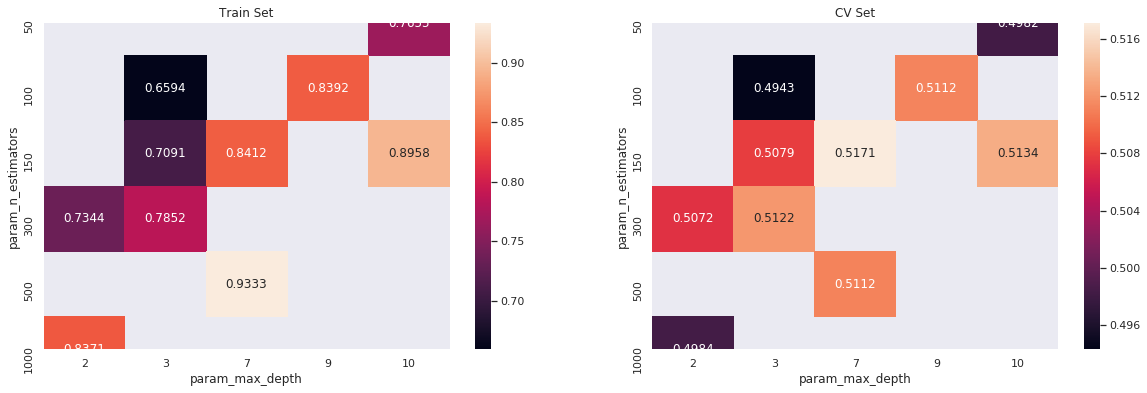

In [66]:

import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(gs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [0]:
max_d = gs_results.best_params_['max_depth']
n_est = gs_results.best_params_['n_estimators']

In [0]:

def pred_prob(clf, data): 
    y_pred = []
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

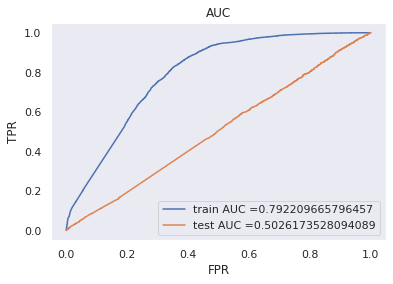

In [69]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
model = RandomForestClassifier(max_depth = max_d, n_estimators = n_est)

model.fit(X_tr,y_train)
    
y_train_pred = pred_prob(model,X_tr)
y_test_pred = pred_prob(model,X_te)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

In [0]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [71]:
#our objective here is to make auc the maximum
#so we find  the best threshold that will give the least fpr
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.5351203557958871 for threshold 0.846
Train confusion matrix
[[ 2336  1275]
 [ 3428 16409]]


In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

the maximum value of tpr*(1-fpr) 0.5351203557958871 for threshold 0.846
Train confusion matrix


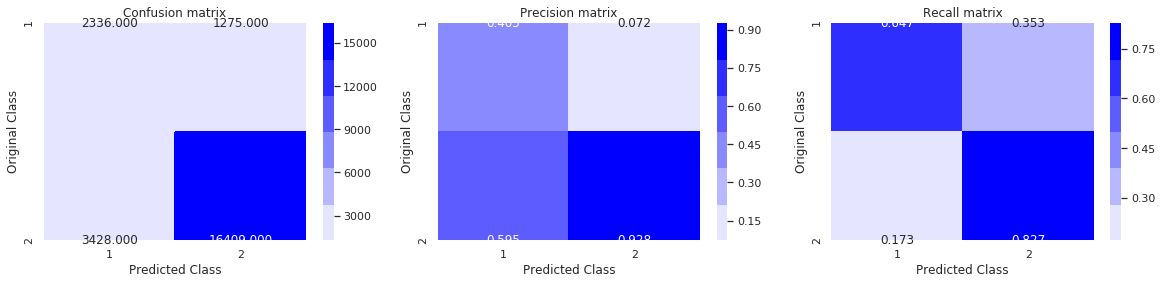

In [73]:
#our objective here is to make auc the maximum
#so we find  the best threshold that will give the least fpr
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

Test confusion matrix


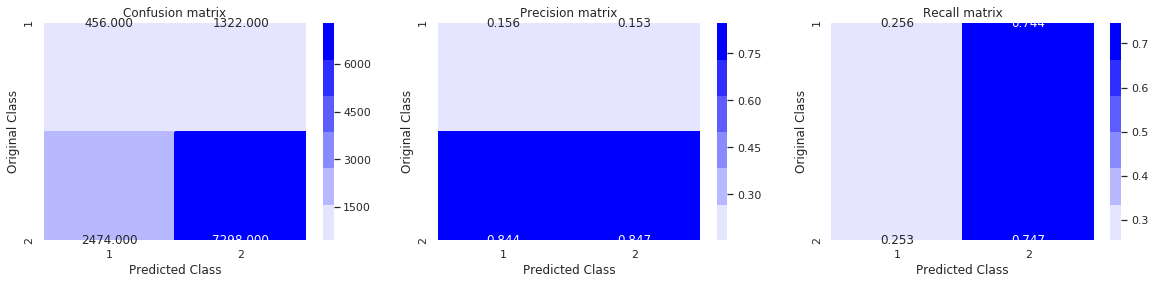

In [74]:
print("Test confusion matrix")
plot_confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

### 2.4.1 Applying Random Forest on TFIDF,<font color='red'> SET 2</font>

In [75]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_title_tfidf, X_train_essay_tfidf, train_categories_feature_responseCoding,train_subcategories_feature_responseCoding, train_teacher_feature_responseCoding,train_grade_feature_responseCoding,X_train_price_norm,X_train_quantity_norm,X_train_teacherno_norm,X_train_essaywords_norm,X_train_titleno_norm,X_train_compoundr_norm,X_train_posr_norm,X_train_neur_norm,X_train_negr_norm)).tocsr()
X_te = hstack((X_test_title_tfidf, X_test_essay_tfidf, test1_categories_feature_responseCoding,test1_subcategories_feature_responseCoding,test_teacher_feature_responseCoding,test_grade_feature_responseCoding,X_test_price_norm,X_test_quantity_norm,X_test_teacherno_norm,X_test_essaywords_norm,X_test_titleno_norm,X_test_compoundr_norm,X_test_posr_norm,X_test_neur_norm,X_test_negr_norm )).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(23448, 52098) (23448,)
(11550, 52098) (11550,)


In [76]:
clf = RandomForestClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
 
gs = RandomizedSearchCV(clf, grid_params, cv=3, scoring='roc_auc',n_jobs=-1,return_train_score=True)
gs_results = gs.fit(X_tr, y_train)
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

0.5133010091137559
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'n_estimators': 200, 'max_depth': 4}


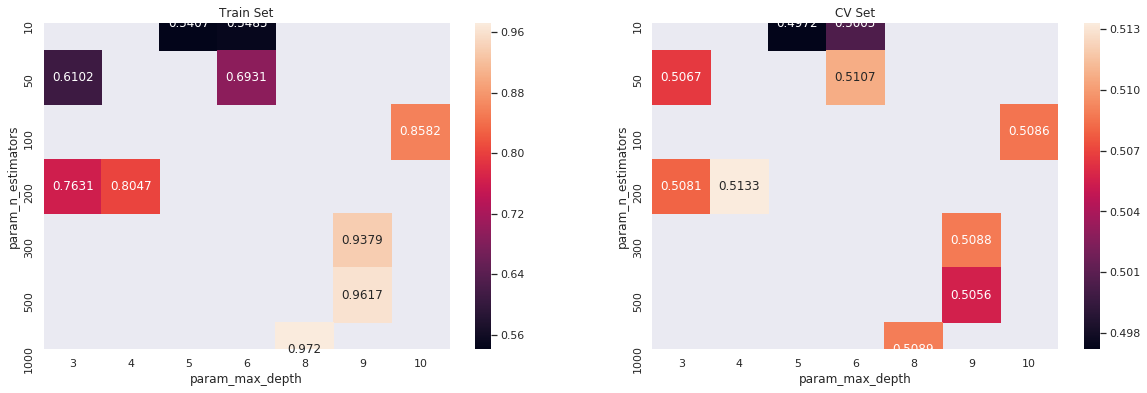

In [77]:
max_scores1 = pd.DataFrame(gs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

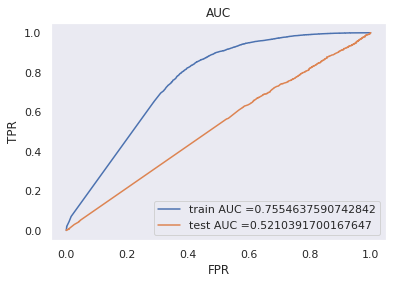

the maximum value of tpr*(1-fpr) 0.4969820012051418 for threshold 0.846
Train confusion matrix


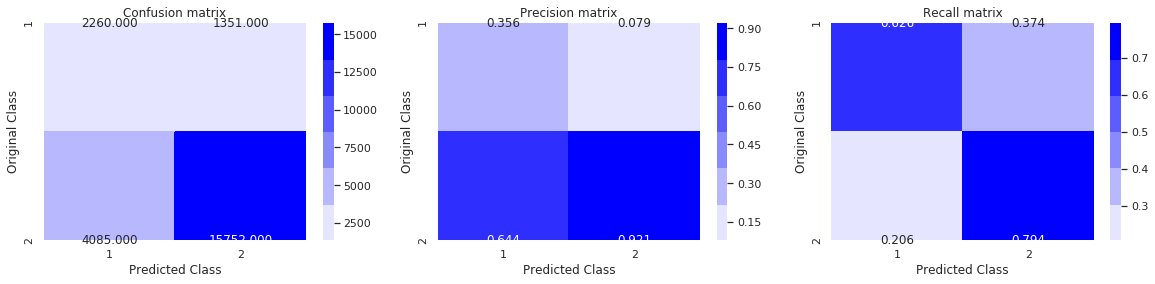

Test confusion matrix


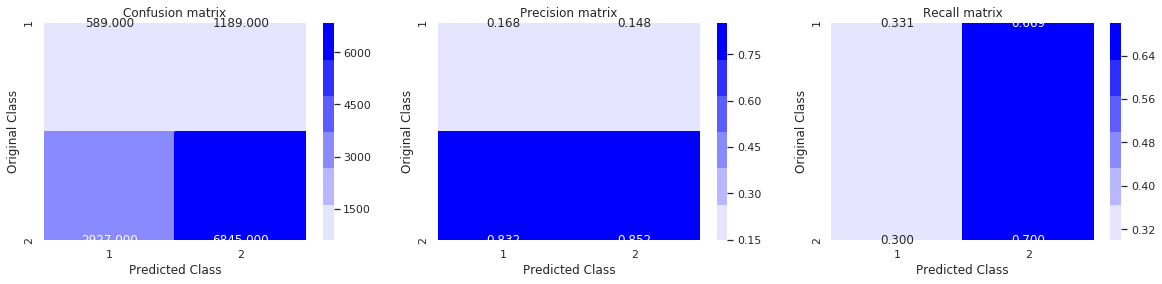

In [78]:
max_d = gs_results.best_params_['max_depth']
n_est = gs_results.best_params_['n_estimators']

model = RandomForestClassifier(max_depth = max_d, n_estimators = n_est)

model.fit(X_tr,y_train)
    
y_train_pred = pred_prob(model,X_tr)
y_test_pred = pred_prob(model,X_te)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

print("Test confusion matrix")
plot_confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

### 2.4.3 Applying Random Forest on AVG W2V,<font color='red'> SET 3</font>

In [79]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
X_tr = hstack((X_train_title_avg_w2v, X_train_essay_avg_w2v, train_categories_feature_responseCoding,train_subcategories_feature_responseCoding, train_teacher_feature_responseCoding,train_grade_feature_responseCoding,X_train_price_norm,X_train_quantity_norm,X_train_teacherno_norm,X_train_essaywords_norm,X_train_titleno_norm,X_train_compoundr_norm,X_train_posr_norm,X_train_neur_norm,X_train_negr_norm)).tocsr()
X_te = hstack((X_test_title_avg_w2v, X_test_essay_avg_w2v, test1_categories_feature_responseCoding,test1_subcategories_feature_responseCoding,test_teacher_feature_responseCoding,test_grade_feature_responseCoding,X_test_price_norm,X_test_quantity_norm,X_test_teacherno_norm,X_test_essaywords_norm,X_test_titleno_norm,X_test_compoundr_norm,X_test_posr_norm,X_test_neur_norm,X_test_negr_norm )).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(23448, 17) (23448,)
(11550, 17) (11550,)


0.5042166757180012
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'n_estimators': 10, 'max_depth': 4}


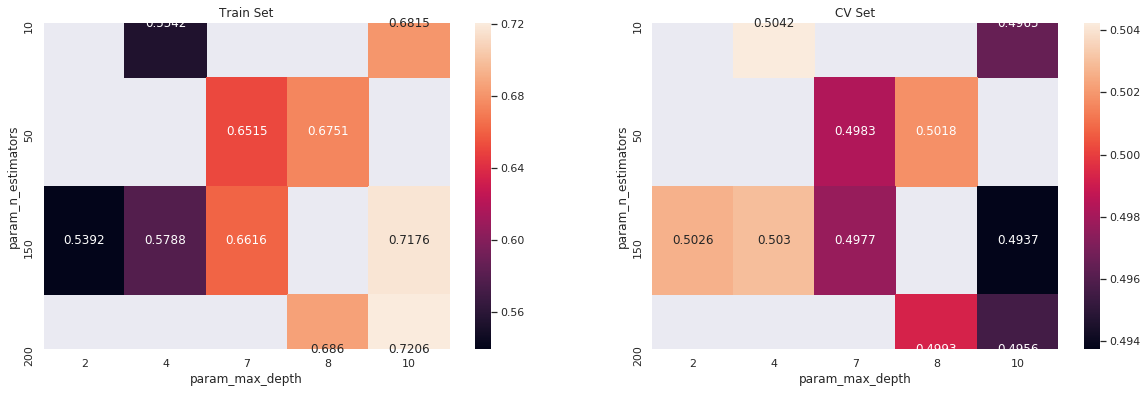

In [80]:
clf = RandomForestClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
 
gs = RandomizedSearchCV(clf, grid_params, cv=3, scoring='roc_auc',n_jobs=-1,return_train_score=True)
gs_results = gs.fit(X_tr, y_train)
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

max_scores1 = pd.DataFrame(gs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

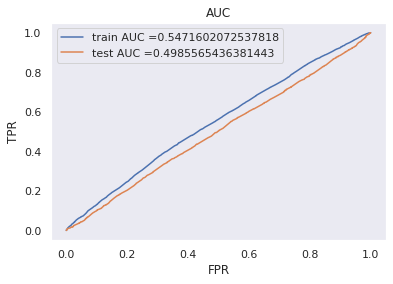

the maximum value of tpr*(1-fpr) 0.28498349892806096 for threshold 0.847
Train confusion matrix


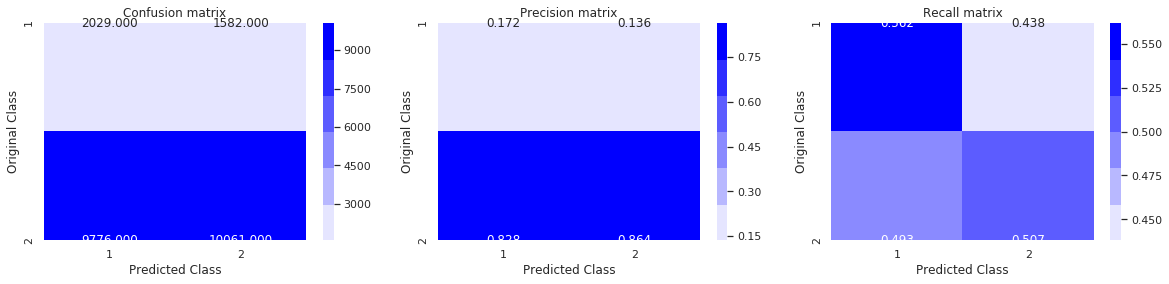

Test confusion matrix


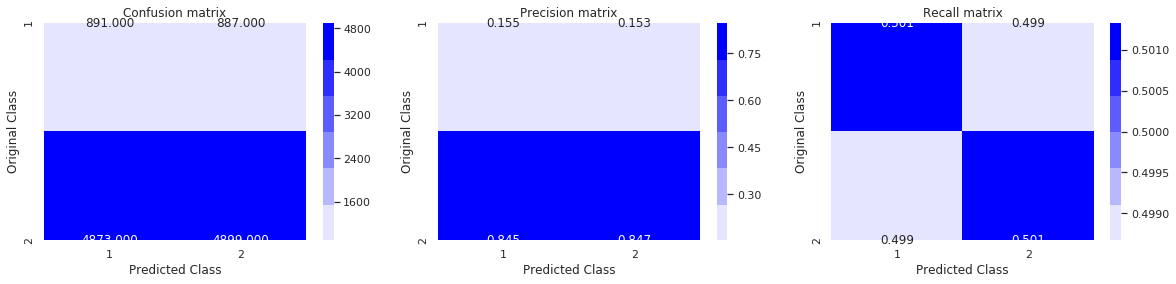

In [81]:
max_d = gs_results.best_params_['max_depth']
n_est = gs_results.best_params_['n_estimators']

model = RandomForestClassifier(max_depth = max_d, n_estimators = n_est)

model.fit(X_tr,y_train)
    
y_train_pred = pred_prob(model,X_tr)
y_test_pred = pred_prob(model,X_te)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

print("Test confusion matrix")
plot_confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

### 2.4.4 Applying Random Forest on TFIDF W2V,<font color='red'> SET 4</font>

In [82]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
X_tr = hstack((X_train_title_tfidf_w2v, X_train_essay_tfidf_w2v, train_categories_feature_responseCoding,train_subcategories_feature_responseCoding, train_teacher_feature_responseCoding,train_grade_feature_responseCoding,X_train_price_norm,X_train_quantity_norm,X_train_teacherno_norm,X_train_essaywords_norm,X_train_titleno_norm,X_train_compoundr_norm,X_train_posr_norm,X_train_neur_norm,X_train_negr_norm)).tocsr()
X_te = hstack((X_test_title_tfidf_w2v, X_test_essay_tfidf_w2v, test1_categories_feature_responseCoding,test1_subcategories_feature_responseCoding,test_teacher_feature_responseCoding,test_grade_feature_responseCoding,X_test_price_norm,X_test_quantity_norm,X_test_teacherno_norm,X_test_essaywords_norm,X_test_titleno_norm,X_test_compoundr_norm,X_test_posr_norm,X_test_neur_norm,X_test_negr_norm )).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(23448, 17) (23448,)
(11550, 17) (11550,)


0.508068263506776
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'n_estimators': 50, 'max_depth': 2}


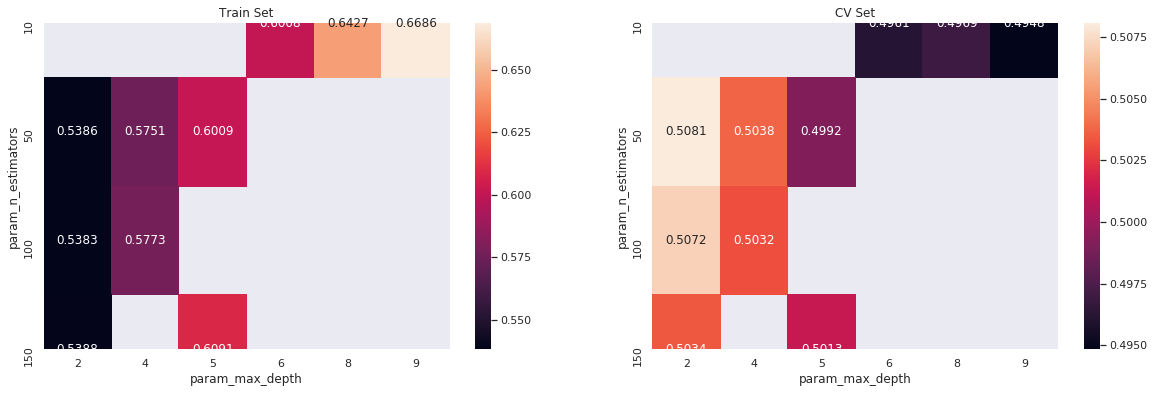

In [83]:
clf = RandomForestClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
 
gs = RandomizedSearchCV(clf, grid_params, cv=3, scoring='roc_auc',n_jobs=-1,return_train_score=True)
gs_results = gs.fit(X_tr, y_train)
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

max_scores1 = pd.DataFrame(gs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

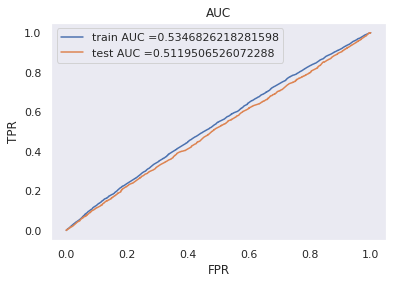

the maximum value of tpr*(1-fpr) 0.2750399695485529 for threshold 0.846
Train confusion matrix


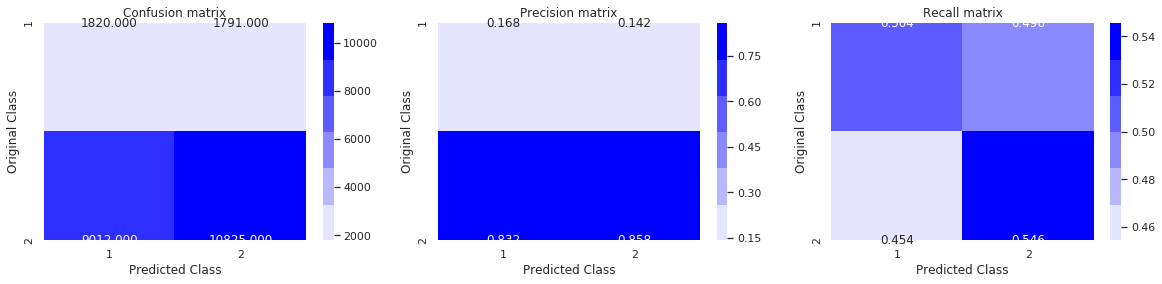

Test confusion matrix


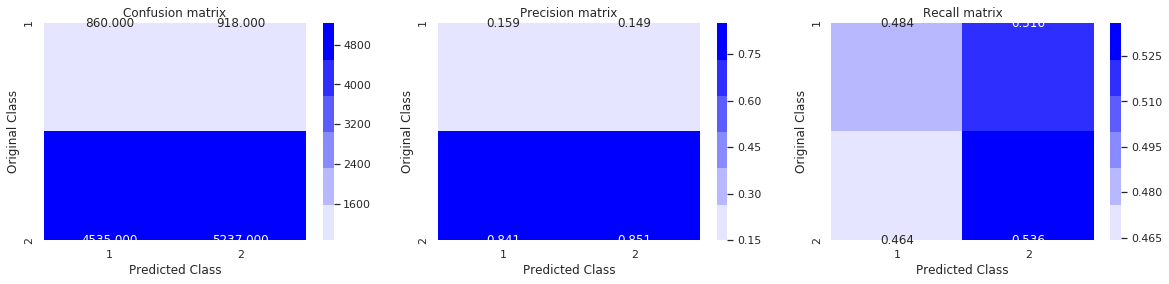

In [84]:
max_d = gs_results.best_params_['max_depth']
n_est = gs_results.best_params_['n_estimators']

model = RandomForestClassifier(max_depth = max_d, n_estimators = n_est)

model.fit(X_tr,y_train)
    
y_train_pred = pred_prob(model,X_tr)
y_test_pred = pred_prob(model,X_te)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

print("Test confusion matrix")
plot_confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

<h2>2.5 Applying GBDT</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### 2.5.1 Applying XGBOOST on BOW,<font color='red'> SET 1</font>


In [85]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
X_tr = hstack((X_train_title_bow, X_train_essay_bow, train_categories_feature_responseCoding,train_subcategories_feature_responseCoding, train_teacher_feature_responseCoding,train_grade_feature_responseCoding,X_train_price_norm,X_train_quantity_norm,X_train_teacherno_norm,X_train_essaywords_norm,X_train_titleno_norm,X_train_compoundr_norm,X_train_posr_norm,X_train_neur_norm,X_train_negr_norm)).tocsr()
X_te = hstack((X_test_title_bow, X_test_essay_bow, test1_categories_feature_responseCoding,test1_subcategories_feature_responseCoding,test_teacher_feature_responseCoding,test_grade_feature_responseCoding,X_test_price_norm,X_test_quantity_norm,X_test_teacherno_norm,X_test_essaywords_norm,X_test_titleno_norm,X_test_compoundr_norm,X_test_posr_norm,X_test_neur_norm,X_test_negr_norm )).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(23448, 52098) (23448,)
(11550, 52098) (11550,)


In [86]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
 
rs = RandomizedSearchCV(gbdt,grid_params ,cv=3, scoring='roc_auc',n_jobs=-1,return_train_score=True)
rs.fit(X_tr, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
          

In [87]:
print('Best score: ',rs.best_score_)
print('k value with best score: ',rs.best_params_)
print('='*75)
print('Train AUC scores')
print(rs.cv_results_['mean_train_score'])
print('CV AUC scores')
print(rs.cv_results_['mean_test_score'])

Best score:  0.5334326895019404
k value with best score:  {'n_estimators': 1000, 'max_depth': 8}
Train AUC scores
[0.91460384 0.99999575 0.88698505 0.98262993 0.93261512 0.76811351
 0.73884628 0.82272509 0.54301452 0.99960923]
CV AUC scores
[0.53170598 0.53343269 0.51960775 0.52732287 0.51876973 0.52600236
 0.52880312 0.52637546 0.51343153 0.52850135]


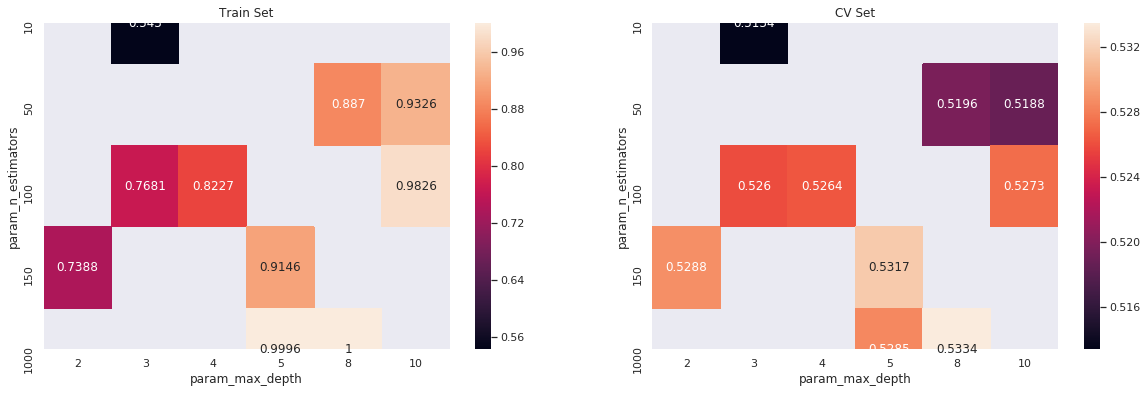

In [88]:
max_scores1 = pd.DataFrame(rs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [0]:

max_d = rs.best_params_['max_depth']
n_est = rs.best_params_['n_estimators']

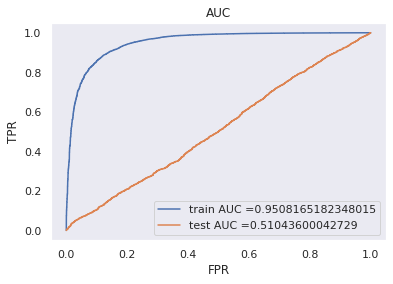

the maximum value of tpr*(1-fpr) 0.7782365631879883 for threshold 0.846
Train confusion matrix


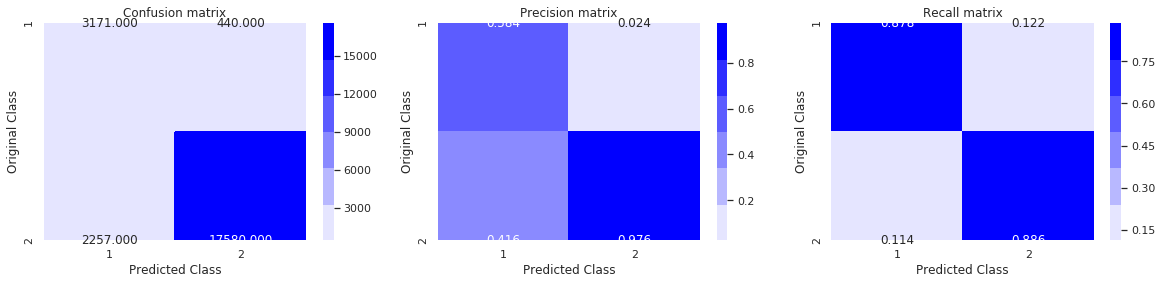

Test confusion matrix


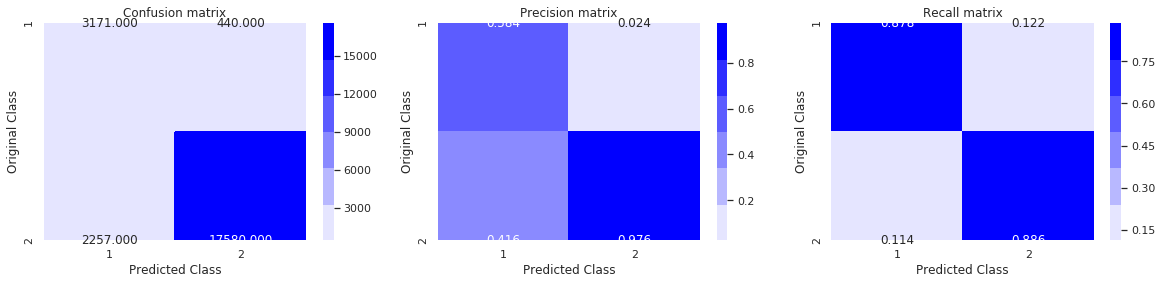

In [90]:
model = RandomForestClassifier(max_depth = max_d, n_estimators = n_est)

model.fit(X_tr,y_train)
    
y_train_pred = pred_prob(model,X_tr)
y_test_pred = pred_prob(model,X_te)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

print("Test confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

### 2.5.2 Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>


In [91]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
X_tr = hstack((X_train_title_tfidf, X_train_essay_tfidf, train_categories_feature_responseCoding,train_subcategories_feature_responseCoding, train_teacher_feature_responseCoding,train_grade_feature_responseCoding,X_train_price_norm,X_train_quantity_norm,X_train_teacherno_norm,X_train_essaywords_norm,X_train_titleno_norm,X_train_compoundr_norm,X_train_posr_norm,X_train_neur_norm,X_train_negr_norm)).tocsr()
X_te = hstack((X_test_title_tfidf, X_test_essay_tfidf, test1_categories_feature_responseCoding,test1_subcategories_feature_responseCoding,test_teacher_feature_responseCoding,test_grade_feature_responseCoding,X_test_price_norm,X_test_quantity_norm,X_test_teacherno_norm,X_test_essaywords_norm,X_test_titleno_norm,X_test_compoundr_norm,X_test_posr_norm,X_test_neur_norm,X_test_negr_norm )).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(23448, 52098) (23448,)
(11550, 52098) (11550,)


In [94]:
gbdt = XGBClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
 
rs = RandomizedSearchCV(gbdt,grid_params ,cv=3, scoring='roc_auc',n_jobs=-1,return_train_score=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
          

KeyboardInterrupt: ignored

In [99]:
rs.fit(X_tr, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
          

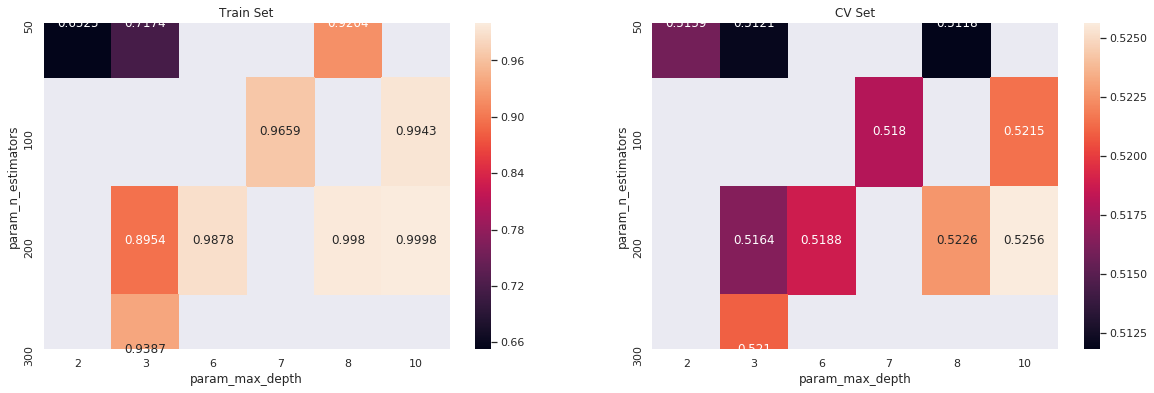

In [100]:
max_scores1 = pd.DataFrame(rs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

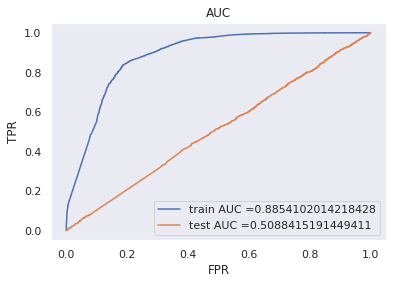

the maximum value of tpr*(1-fpr) 0.6803264383736034 for threshold 0.846
Train confusion matrix


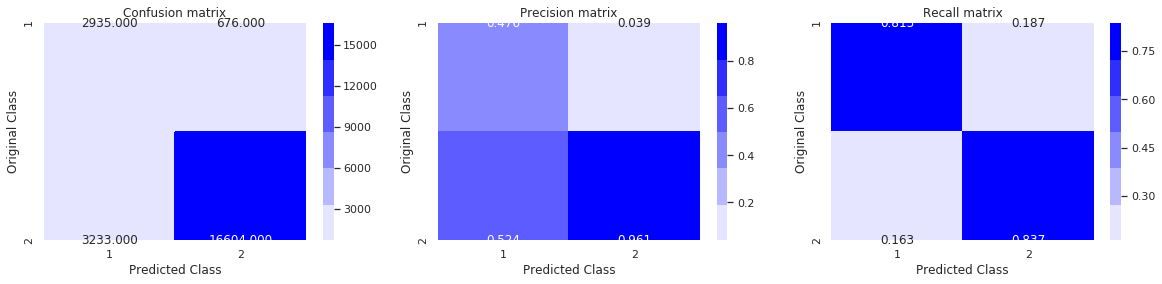

Test confusion matrix


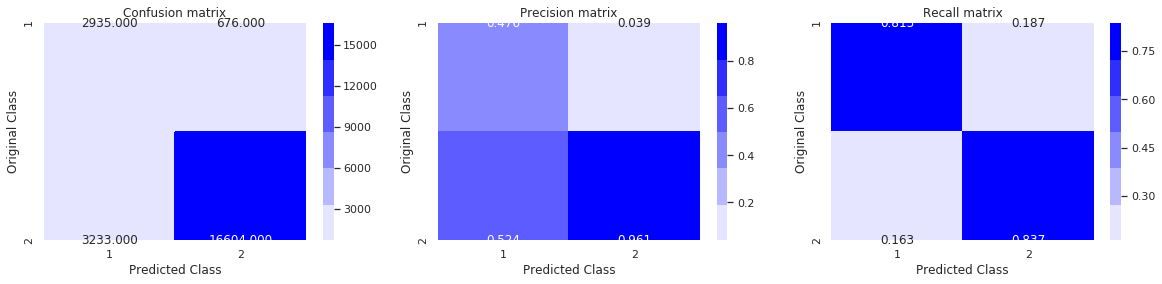

In [101]:

max_d = rs.best_params_['max_depth']
n_est = rs.best_params_['n_estimators']

model = RandomForestClassifier(max_depth = max_d, n_estimators = n_est)

model.fit(X_tr,y_train)
    
y_train_pred = pred_prob(model,X_tr)
y_test_pred = pred_prob(model,X_te)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

print("Test confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

### 2.5.3 Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>


In [102]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
X_tr = hstack((X_train_title_avg_w2v, X_train_essay_avg_w2v, train_categories_feature_responseCoding,train_subcategories_feature_responseCoding, train_teacher_feature_responseCoding,train_grade_feature_responseCoding,X_train_price_norm,X_train_quantity_norm,X_train_teacherno_norm,X_train_essaywords_norm,X_train_titleno_norm,X_train_compoundr_norm,X_train_posr_norm,X_train_neur_norm,X_train_negr_norm)).tocsr()
X_te = hstack((X_test_title_avg_w2v, X_test_essay_avg_w2v, test1_categories_feature_responseCoding,test1_subcategories_feature_responseCoding,test_teacher_feature_responseCoding,test_grade_feature_responseCoding,X_test_price_norm,X_test_quantity_norm,X_test_teacherno_norm,X_test_essaywords_norm,X_test_titleno_norm,X_test_compoundr_norm,X_test_posr_norm,X_test_neur_norm,X_test_negr_norm )).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(23448, 17) (23448,)
(11550, 17) (11550,)


In [103]:
gbdt = XGBClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
 
rs = RandomizedSearchCV(gbdt,grid_params ,cv=3, scoring='roc_auc',n_jobs=-1,return_train_score=True)
rs.fit(X_tr, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
          

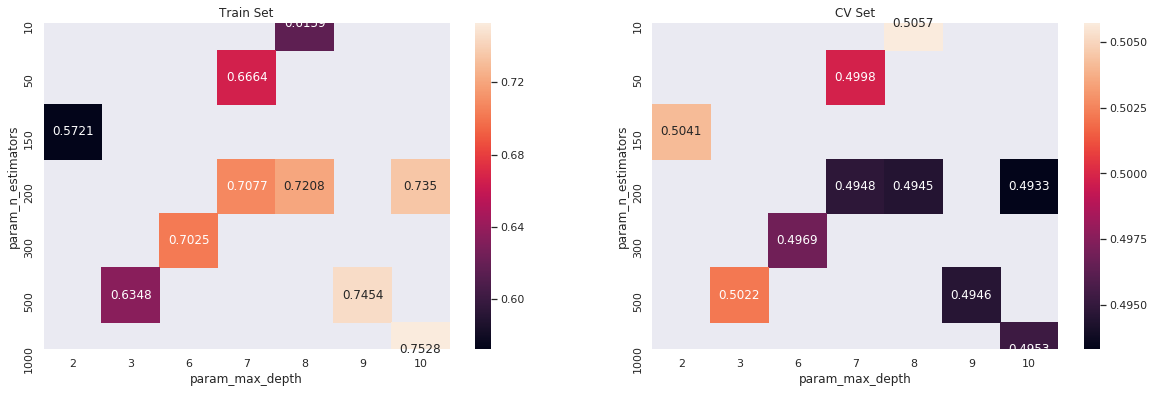

In [104]:
max_scores1 = pd.DataFrame(rs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

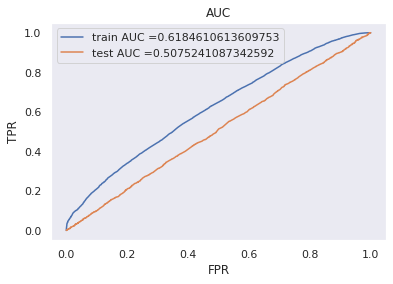

the maximum value of tpr*(1-fpr) 0.3336076031565316 for threshold 0.844
Train confusion matrix


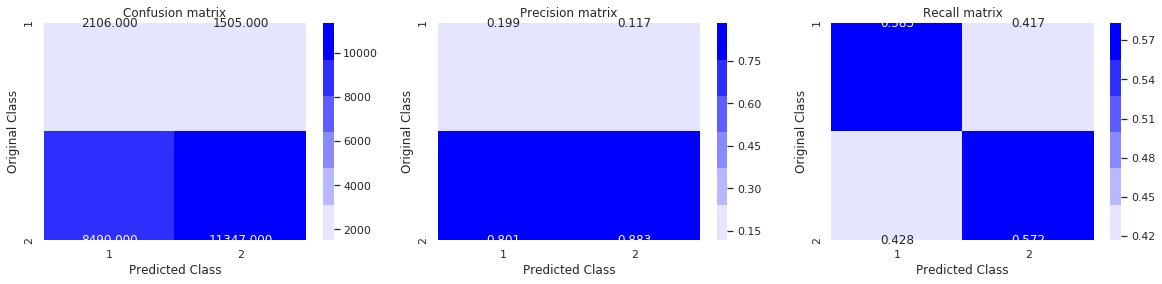

Test confusion matrix


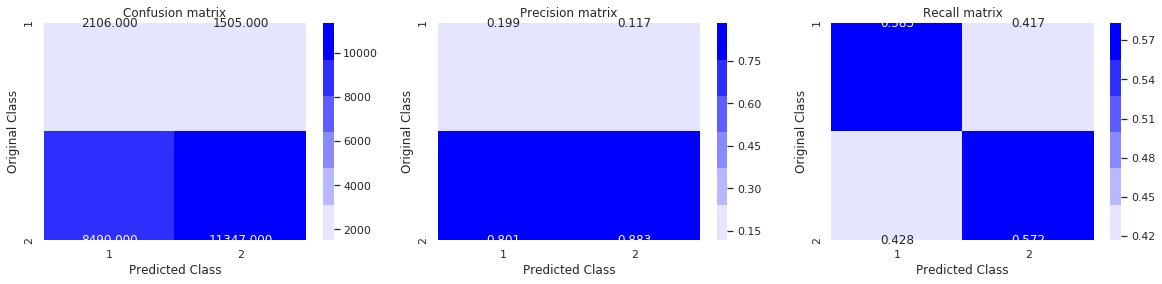

In [105]:

max_d = rs.best_params_['max_depth']
n_est = rs.best_params_['n_estimators']

model = RandomForestClassifier(max_depth = max_d, n_estimators = n_est)

model.fit(X_tr,y_train)
    
y_train_pred = pred_prob(model,X_tr)
y_test_pred = pred_prob(model,X_te)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

print("Test confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

### 2.5.4 Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [106]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
X_tr = hstack((X_train_title_tfidf_w2v, X_train_essay_tfidf_w2v, train_categories_feature_responseCoding,train_subcategories_feature_responseCoding, train_teacher_feature_responseCoding,train_grade_feature_responseCoding,X_train_price_norm,X_train_quantity_norm,X_train_teacherno_norm,X_train_essaywords_norm,X_train_titleno_norm,X_train_compoundr_norm,X_train_posr_norm,X_train_neur_norm,X_train_negr_norm)).tocsr()
X_te = hstack((X_test_title_tfidf_w2v, X_test_essay_tfidf_w2v, test1_categories_feature_responseCoding,test1_subcategories_feature_responseCoding,test_teacher_feature_responseCoding,test_grade_feature_responseCoding,X_test_price_norm,X_test_quantity_norm,X_test_teacherno_norm,X_test_essaywords_norm,X_test_titleno_norm,X_test_compoundr_norm,X_test_posr_norm,X_test_neur_norm,X_test_negr_norm )).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(23448, 17) (23448,)
(11550, 17) (11550,)


In [107]:
gbdt = XGBClassifier()

grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
 
rs = RandomizedSearchCV(gbdt,grid_params ,cv=3, scoring='roc_auc',n_jobs=-1,return_train_score=True)
rs.fit(X_tr, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
          

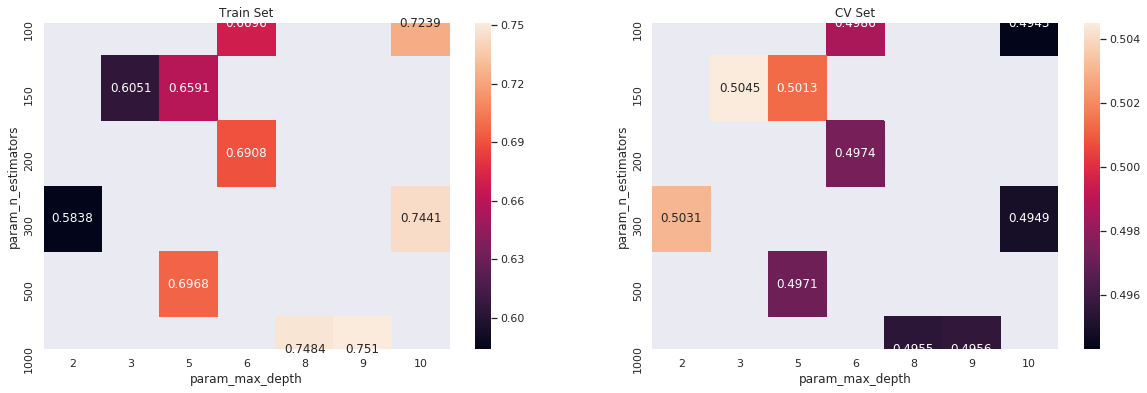

In [108]:
max_scores1 = pd.DataFrame(rs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

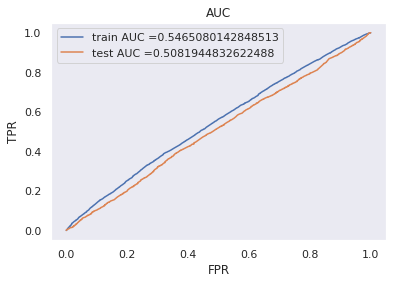

the maximum value of tpr*(1-fpr) 0.28244644140523445 for threshold 0.847
Train confusion matrix


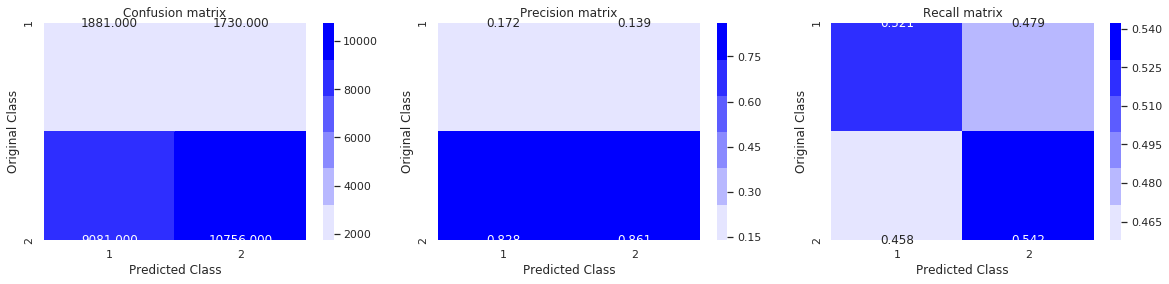

Test confusion matrix


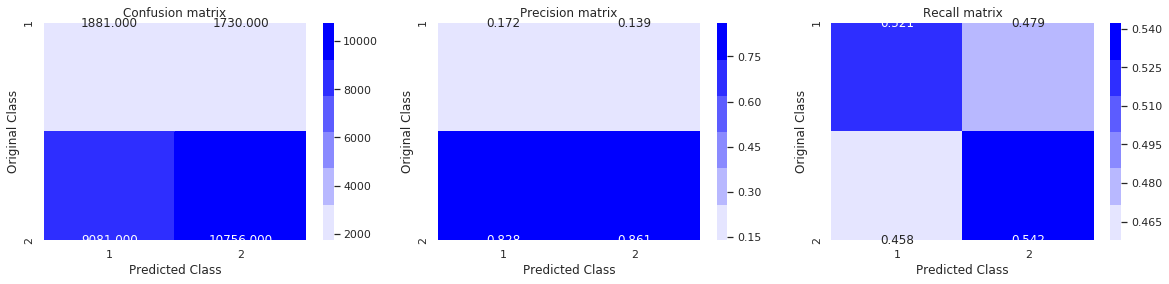

In [109]:

max_d = rs.best_params_['max_depth']
n_est = rs.best_params_['n_estimators']

model = RandomForestClassifier(max_depth = max_d, n_estimators = n_est)

model.fit(X_tr,y_train)
    
y_train_pred = pred_prob(model,X_tr)
y_test_pred = pred_prob(model,X_te)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

print("Test confusion matrix")
plot_confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

<h1> Pretty Table</h1>

In [3]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "n_estimators", "max_depth", "AUC"]

x.add_row(["BOW", "RF", 150, 7, 0.50])
x.add_row(["TFIDF", "RF", 200, 4, 0.52])
x.add_row(["AVG W2V", "RF", 200, 4,0.49])
x.add_row(["TFIDF-W2V", "RF", 200, 3,0.51])
x.add_row(["BOW", "GBDT", 100, 3, 0.51])
x.add_row(["TFIDF", "GBDT", 150, 3, 0.50])
x.add_row(["AVG W2V", "GBDT", 200, 4,0.51])
x.add_row(["TFIDF-W2V", "GBDT", 200, 3,0.51])

print(x)

+------------+-------+--------------+-----------+------+
| Vectorizer | Model | n_estimators | max_depth | AUC  |
+------------+-------+--------------+-----------+------+
|    BOW     |   RF  |     150      |     7     | 0.5  |
|   TFIDF    |   RF  |     200      |     4     | 0.52 |
|  AVG W2V   |   RF  |     200      |     4     | 0.49 |
| TFIDF-W2V  |   RF  |     200      |     3     | 0.51 |
|    BOW     |  GBDT |     100      |     3     | 0.51 |
|   TFIDF    |  GBDT |     150      |     3     | 0.5  |
|  AVG W2V   |  GBDT |     200      |     4     | 0.51 |
| TFIDF-W2V  |  GBDT |     200      |     3     | 0.51 |
+------------+-------+--------------+-----------+------+


<h1>3. Conclusions</h1>

1. The SVM model on TF-IDF W2V vectorized data gives the best AUC.
2. All the models can be seen close to a random model.
3. The number of estimators ranged from 100 to 200 and maximum tree depth went upto 7.